In [4]:
# EV車両データのクラスタリング分析
# hashvinごとにDBSCANとHDBSCANを実行し、結果を比較

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import hdbscan
import folium
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = 'Yu Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("必要なライブラリのインポート完了")

必要なライブラリのインポート完了


=== テストデータの生成 ===
生成されたテストデータ:
  車両数: 5
  総データポイント数: 1000
  各車両のデータポイント数: 200
  緯度範囲: 33.4996 ~ 43.1404
  経度範囲: 130.3135 ~ 141.4478
  idle_time範囲: 0.2 ~ 480.0分


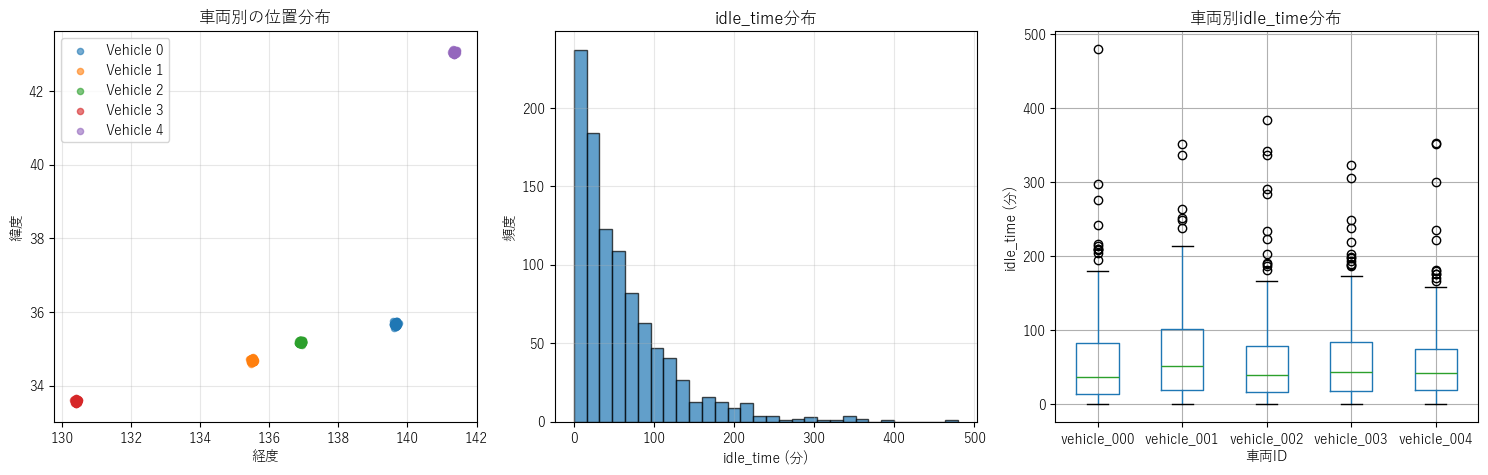


テストデータの基本統計:
             lat_m        lon_m    idle_time
count  1000.000000  1000.000000  1000.000000
mean     36.439233   136.765301    60.820273
std       3.382977     3.784166    62.123286
min      33.499615   130.313488     0.193407
25%      34.674154   135.485986    17.896199
50%      35.183237   136.907910    42.257905
75%      35.691270   139.675821    82.986818
max      43.140424   141.447798   480.000000


In [5]:
# テストデータの生成
print("=== テストデータの生成 ===")

np.random.seed(42)  # 再現性のため

# テストデータの生成
n_vehicles = 5  # 車両数
n_points_per_vehicle = 200  # 各車両のデータポイント数

test_data = []

for vehicle_id in range(n_vehicles):
    # 各車両の拠点位置（東京、大阪、名古屋、福岡、札幌周辺）
    base_locations = [
        (35.6762, 139.6503),  # 東京
        (34.6937, 135.5023),  # 大阪
        (35.1815, 136.9066),  # 名古屋
        (33.5902, 130.4017),  # 福岡
        (43.0618, 141.3545),  # 札幌
    ]
    
    base_lat, base_lon = base_locations[vehicle_id]
    
    # 各車両の拠点周辺にデータポイントを生成
    for i in range(n_points_per_vehicle):
        # 緯度経度のばらつき（約5km程度）
        lat_std = 0.03  # 約3.3km
        lon_std = 0.03  # 約3.3km
        
        lat = np.random.normal(base_lat, lat_std)
        lon = np.random.normal(base_lon, lon_std)
        
        # idle_time（分単位、0-480分の範囲）
        idle_time = np.random.exponential(60)  # 平均60分の指数分布
        idle_time = min(idle_time, 480)  # 最大480分
        
        test_data.append({
            'hashvin': f'vehicle_{vehicle_id:03d}',
            'lat_m': lat,
            'lon_m': lon,
            'idle_time': idle_time
        })

# DataFrameに変換
df_test = pd.DataFrame(test_data)

print(f"生成されたテストデータ:")
print(f"  車両数: {df_test['hashvin'].nunique()}")
print(f"  総データポイント数: {len(df_test)}")
print(f"  各車両のデータポイント数: {n_points_per_vehicle}")
print(f"  緯度範囲: {df_test['lat_m'].min():.4f} ~ {df_test['lat_m'].max():.4f}")
print(f"  経度範囲: {df_test['lon_m'].min():.4f} ~ {df_test['lon_m'].max():.4f}")
print(f"  idle_time範囲: {df_test['idle_time'].min():.1f} ~ {df_test['idle_time'].max():.1f}分")

# データの可視化
plt.figure(figsize=(15, 5))

# 車両別の位置分布
plt.subplot(1, 3, 1)
for vehicle_id in range(n_vehicles):
    vehicle_data = df_test[df_test['hashvin'] == f'vehicle_{vehicle_id:03d}']
    plt.scatter(vehicle_data['lon_m'], vehicle_data['lat_m'], 
               alpha=0.6, s=20, label=f'Vehicle {vehicle_id}')
plt.title('車両別の位置分布')
plt.xlabel('経度')
plt.ylabel('緯度')
plt.legend()
plt.grid(True, alpha=0.3)

# idle_time分布
plt.subplot(1, 3, 2)
plt.hist(df_test['idle_time'], bins=30, alpha=0.7, edgecolor='black')
plt.title('idle_time分布')
plt.xlabel('idle_time (分)')
plt.ylabel('頻度')
plt.grid(True, alpha=0.3)

# 車両別idle_time分布
plt.subplot(1, 3, 3)
df_test.boxplot(column='idle_time', by='hashvin', ax=plt.gca())
plt.title('車両別idle_time分布')
plt.suptitle('')  # サブタイトルを削除
plt.xlabel('車両ID')
plt.ylabel('idle_time (分)')

plt.tight_layout()
plt.show()

# テストデータの基本統計
print("\nテストデータの基本統計:")
print(df_test.describe())

### データの前処理とスケーリング

In [6]:
# データの前処理とスケーリング
print("=== データの前処理とスケーリング ===")

# テストデータを使用
df = df_test.copy()

# データの基本統計
print("データの基本統計:")
print(df.describe())

# 緯度経度をメートル単位に変換（近似）
# 1度の緯度 ≈ 111,000 m
# 1度の経度 ≈ 111,000 * cos(緯度) m

def lat_lon_to_meters(lat, lon):
    """緯度経度をメートル単位に変換（簡易版）"""
    lat_m = lat * 111000  # 緯度をメートルに変換
    lon_m = lon * 111000 * np.cos(np.radians(lat))  # 経度をメートルに変換
    return lat_m, lon_m

# メートル単位に変換
df['lat_m_scaled'] = df['lat_m'] * 111000
df['lon_m_scaled'] = df['lon_m'] * 111000 * np.cos(np.radians(df['lat_m']))

# idle_timeも正規化（0-1の範囲に）
df['idle_time_normalized'] = (df['idle_time'] - df['idle_time'].min()) / (df['idle_time'].max() - df['idle_time'].min())

# スケーリング用のデータ（位置情報のみ）
X_position = df[['lat_m_scaled', 'lon_m_scaled']].values

# 位置情報 + idle_timeを含むデータ
X_full = df[['lat_m_scaled', 'lon_m_scaled', 'idle_time_normalized']].values

print("\nスケーリング後のデータ形状:")
print(f"  位置情報のみ: {X_position.shape}")
print(f"  位置情報 + idle_time: {X_full.shape}")

print("\nスケーリング後の基本統計:")
print(pd.DataFrame(X_position, columns=['lat_m_scaled', 'lon_m_scaled']).describe())

print("\nidle_time正規化後の基本統計:")
print(df[['idle_time', 'idle_time_normalized']].describe())

=== データの前処理とスケーリング ===
データの基本統計:
             lat_m        lon_m    idle_time
count  1000.000000  1000.000000  1000.000000
mean     36.439233   136.765301    60.820273
std       3.382977     3.784166    62.123286
min      33.499615   130.313488     0.193407
25%      34.674154   135.485986    17.896199
50%      35.183237   136.907910    42.257905
75%      35.691270   139.675821    82.986818
max      43.140424   141.447798   480.000000

スケーリング後のデータ形状:
  位置情報のみ: (1000, 2)
  位置情報 + idle_time: (1000, 3)

スケーリング後の基本統計:
       lat_m_scaled  lon_m_scaled
count  1.000000e+03  1.000000e+03
mean   4.044755e+06  1.218054e+07
std    3.755105e+05  3.978219e+05
min    3.718457e+06  1.144623e+07
25%    3.848831e+06  1.205498e+07
50%    3.905339e+06  1.236715e+07
75%    3.961731e+06  1.242431e+07
max    4.788587e+06  1.260669e+07

idle_time正規化後の基本統計:
         idle_time  idle_time_normalized
count  1000.000000           1000.000000
mean     60.820273              0.126357
std      62.123286             

###  hashvinごとのクラスタリング分析（DBSCAN・HDBSCAN）

=== hashvinごとのクラスタリング分析 ===

--- vehicle_000 の分析 ---
データポイント数: 200

--- DBSCANパラメータチューニング ---

DBSCANパラメータチューニング結果（上位5件）:
     eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette_score
1    500            5           8      144        0.720          0.679302
0    500            3          18       95        0.475          0.504545
7   1000           10           3       97        0.485          0.357441
10  2000            3           3        4        0.020          0.331424
6   1000            5           3       48        0.240          0.280571

DBSCAN最良パラメータ: eps=500, min_samples=5
DBSCAN最良シルエットスコア: 0.6793

--- HDBSCANパラメータチューニング ---

HDBSCANパラメータチューニング結果（上位5件）:
    min_cluster_size  min_samples  n_clusters  n_noise  noise_ratio  \
11                15            5           2      123        0.615   
0                  5            3           2       18        0.090   
5                 10            3           2       18        0.090   
10                15         

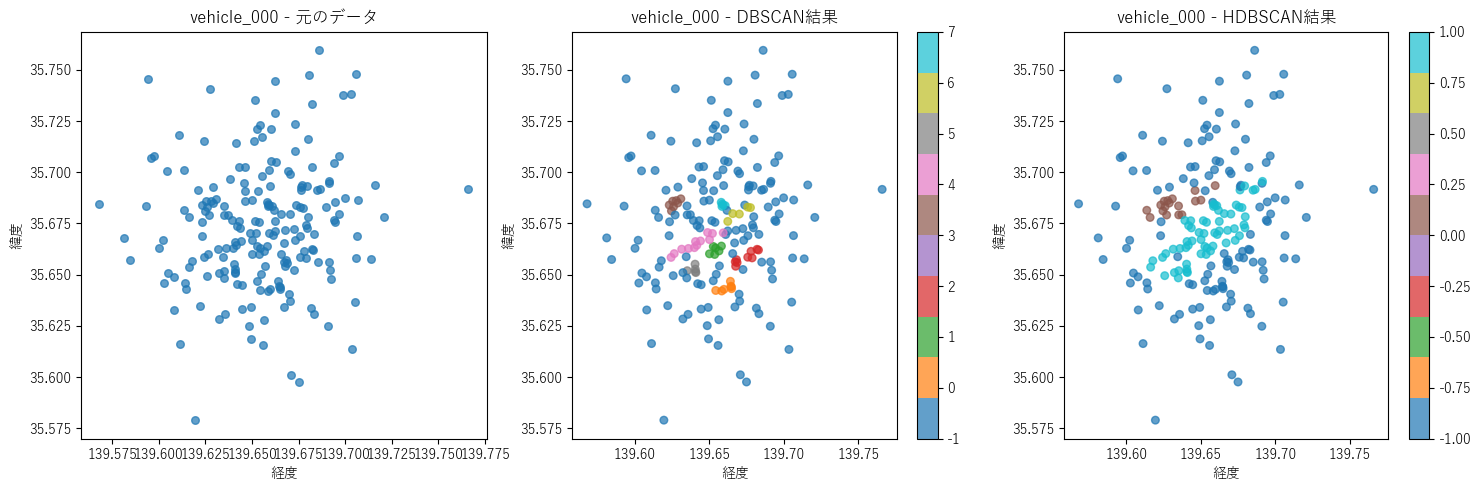


--- vehicle_001 の分析 ---
データポイント数: 200

--- DBSCANパラメータチューニング ---

DBSCANパラメータチューニング結果（上位5件）:
    eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette_score
1   500            5           5      160        0.800          0.661346
0   500            3          16       98        0.490          0.459371
7  1000           10           2      110        0.550          0.428561
6  1000            5           4       52        0.260          0.230555
5  1000            3           6       23        0.115          0.092418

DBSCAN最良パラメータ: eps=500, min_samples=5
DBSCAN最良シルエットスコア: 0.6613

--- HDBSCANパラメータチューニング ---

HDBSCANパラメータチューニング結果（上位5件）:
    min_cluster_size  min_samples  n_clusters  n_noise  noise_ratio  \
16                20            5           2      118        0.590   
11                15            5           2      118        0.590   
10                15            3           2       31        0.155   
15                20            3           2       31        0

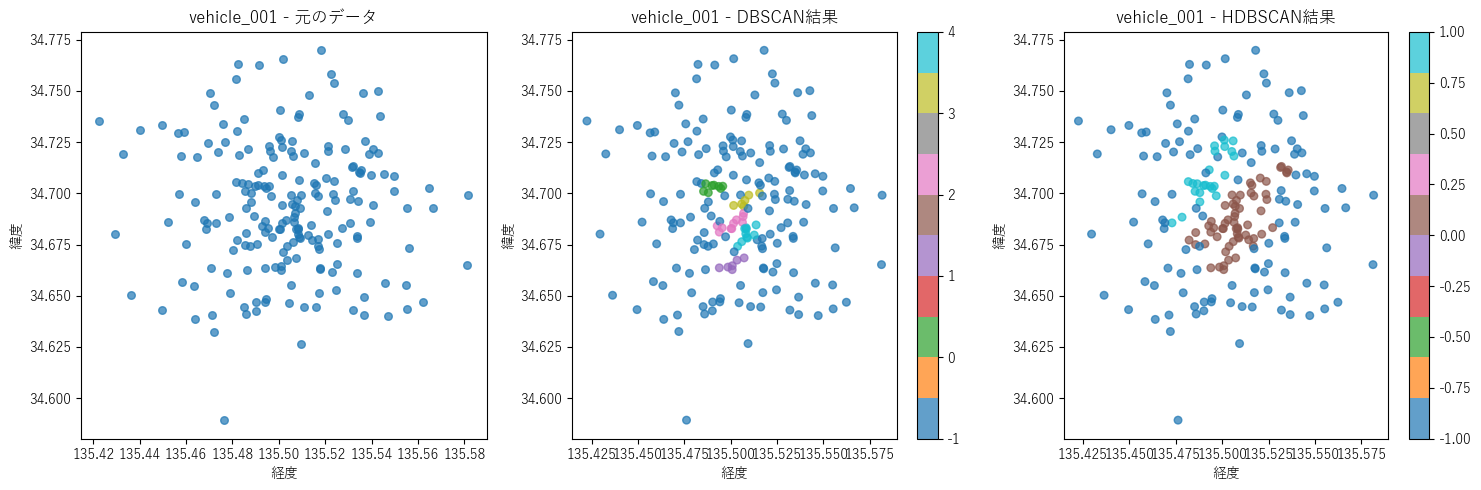


--- vehicle_002 の分析 ---
データポイント数: 200

--- DBSCANパラメータチューニング ---

DBSCANパラメータチューニング結果（上位5件）:
     eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette_score
1    500            5           3      183        0.915          0.878378
7   1000           10           4      117        0.585          0.597247
10  2000            3           2        5        0.025          0.543021
11  2000            5           2        5        0.025          0.543021
0    500            3          17      116        0.580          0.526267

DBSCAN最良パラメータ: eps=500, min_samples=5
DBSCAN最良シルエットスコア: 0.8784

--- HDBSCANパラメータチューニング ---

HDBSCANパラメータチューニング結果（上位5件）:
    min_cluster_size  min_samples  n_clusters  n_noise  noise_ratio  \
4                  5           20           2      148        0.740   
9                 10           20           2      148        0.740   
14                15           20           2      148        0.740   
13                15           15           2      148   

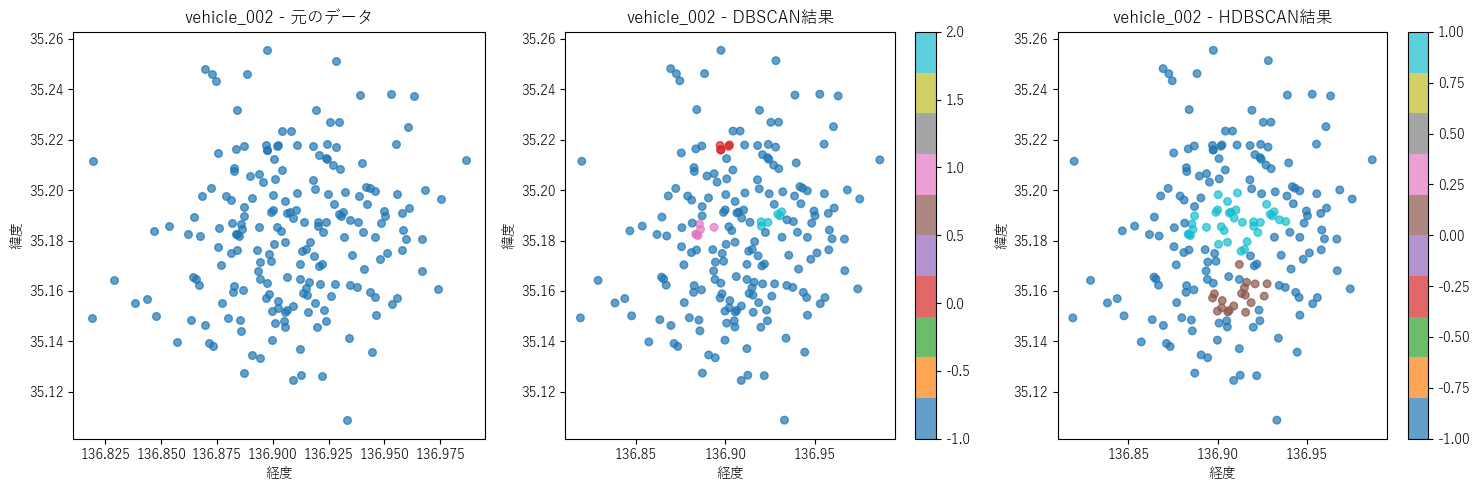


--- vehicle_003 の分析 ---
データポイント数: 200

--- DBSCANパラメータチューニング ---

DBSCANパラメータチューニング結果（上位5件）:
     eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette_score
6   1000            5           2       61        0.305          0.553995
1    500            5           5      154        0.770          0.457740
0    500            3          13       96        0.480          0.431948
10  2000            3           2        6        0.030          0.393852
5   1000            3           7       31        0.155         -0.009270

DBSCAN最良パラメータ: eps=1000, min_samples=5
DBSCAN最良シルエットスコア: 0.5540

--- HDBSCANパラメータチューニング ---

HDBSCANパラメータチューニング結果（上位5件）:
    min_cluster_size  min_samples  n_clusters  n_noise  noise_ratio  \
2                  5           10           2      182        0.910   
10                15            3           2      160        0.800   
5                 10            3           3       68        0.340   
0                  5            3           5       58  

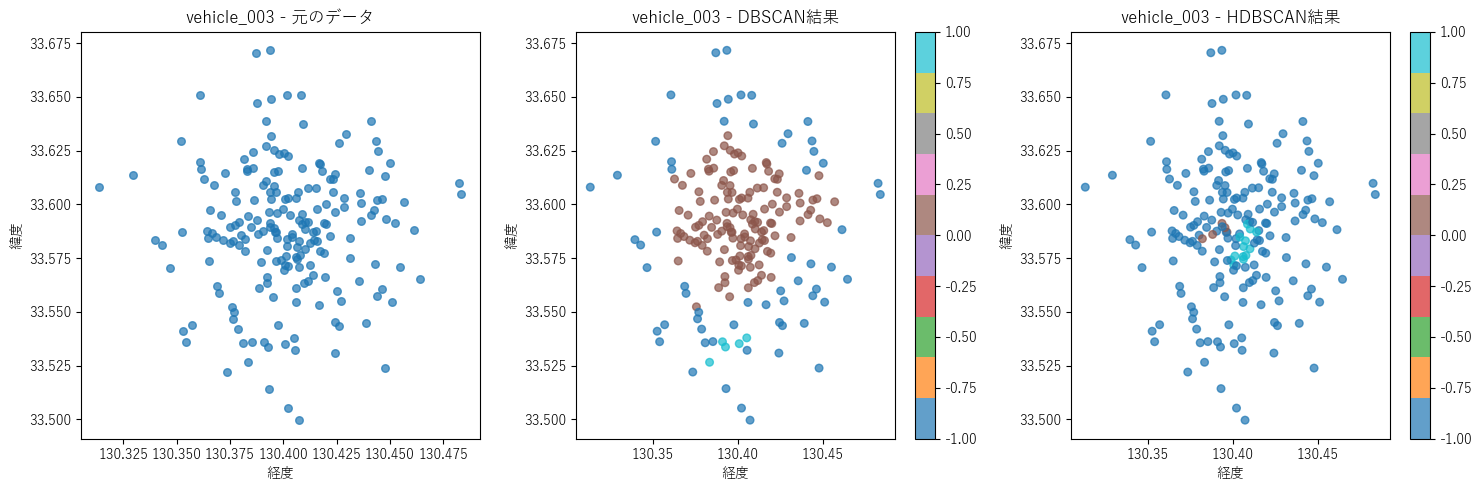


--- vehicle_004 の分析 ---
データポイント数: 200

--- DBSCANパラメータチューニング ---

DBSCANパラメータチューニング結果（上位5件）:
     eps  min_samples  n_clusters  n_noise  noise_ratio  silhouette_score
8   1000           15           2      157        0.785          0.865023
1    500            5          10      132        0.660          0.588903
10  2000            3           2        4        0.020          0.523825
6   1000            5           3       32        0.160          0.474467
5   1000            3           6       17        0.085          0.462194

DBSCAN最良パラメータ: eps=1000, min_samples=15
DBSCAN最良シルエットスコア: 0.8650

--- HDBSCANパラメータチューニング ---

HDBSCANパラメータチューニング結果（上位5件）:
    min_cluster_size  min_samples  n_clusters  n_noise  noise_ratio  \
13                15           15           2      109        0.545   
9                 10           20           2      129        0.645   
4                  5           20           2      129        0.645   
16                20            5           2       60 

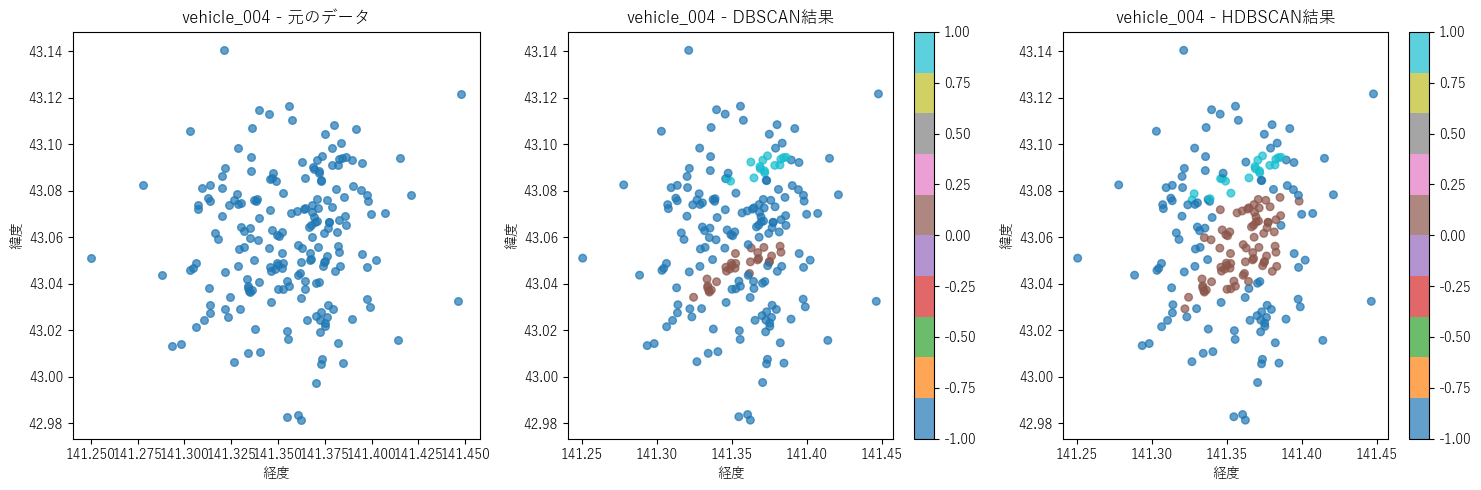


車両別クラスタリング分析完了: 5車両


In [26]:
# hashvinごとのクラスタリング分析
print("=== hashvinごとのクラスタリング分析 ===")

# 各車両に対して個別にクラスタリングを実行
vehicle_clustering_results = {}

# パラメータの範囲設定
eps_values = [500, 1000, 2000, 5000, 10000]  # メートル
min_samples_values = [3, 5, 10, 15, 20]
min_cluster_size_values = [5, 10, 15, 20, 30]

for vehicle_id in range(n_vehicles):
    vehicle_hashvin = f'vehicle_{vehicle_id:03d}'
    vehicle_data = df[df['hashvin'] == vehicle_hashvin]
    
    print(f"\n{'='*60}")
    print(f"--- {vehicle_hashvin} の分析 ---")
    print(f"データポイント数: {len(vehicle_data)}")
    print(f"{'='*60}")
    
    if len(vehicle_data) < 10:
        print("データポイントが少なすぎるため、クラスタリングをスキップ")
        continue
    
    # 車両データの位置情報
    X_vehicle = vehicle_data[['lat_m_scaled', 'lon_m_scaled']].values
    
    # DBSCANパラメータチューニング
    print("\n--- DBSCANパラメータチューニング ---")
    best_dbscan_score = -1
    best_dbscan_params = {}
    best_dbscan_labels = None
    
    results_dbscan = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            # DBSCAN実行
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X_vehicle)
            
            # クラスタリング結果の評価
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_ratio = n_noise / len(labels)
            
            # シルエットスコア（ノイズ点を除く）
            if n_clusters > 1:
                mask = labels != -1
                if sum(mask) > 1:
                    try:
                        silhouette_avg = silhouette_score(X_vehicle[mask], labels[mask])
                    except:
                        silhouette_avg = -1
                else:
                    silhouette_avg = -1
            else:
                silhouette_avg = -1
            
            results_dbscan.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': noise_ratio,
                'silhouette_score': silhouette_avg
            })
            
            # 最良の結果を記録
            if silhouette_avg > best_dbscan_score and n_clusters > 0 and silhouette_avg != -1:
                best_dbscan_score = silhouette_avg
                best_dbscan_params = {'eps': eps, 'min_samples': min_samples}
                best_dbscan_labels = labels.copy()
    
    # DBSCAN結果をDataFrameで表示
    results_dbscan_df = pd.DataFrame(results_dbscan)
    print("\nDBSCANパラメータチューニング結果（上位5件）:")
    print(results_dbscan_df.sort_values('silhouette_score', ascending=False).head())
    
    if best_dbscan_params:
        print(f"\nDBSCAN最良パラメータ: eps={best_dbscan_params['eps']}, min_samples={best_dbscan_params['min_samples']}")
        print(f"DBSCAN最良シルエットスコア: {best_dbscan_score:.4f}")
    else:
        print("DBSCANで有効なクラスタリング結果が得られませんでした。")
        best_dbscan_labels = np.full(len(vehicle_data), -1)  # 全ポイントをノイズとして扱う
    
    # HDBSCANパラメータチューニング
    print("\n--- HDBSCANパラメータチューニング ---")
    best_hdbscan_score = -1
    best_hdbscan_params = {}
    best_hdbscan_labels = None
    
    results_hdbscan = []
    
    for min_cluster_size in min_cluster_size_values:
        for min_samples in min_samples_values:
            # HDBSCAN実行
            hdbscan_clusterer = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                metric='euclidean'
            )
            labels = hdbscan_clusterer.fit_predict(X_vehicle)
            
            # クラスタリング結果の評価
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_ratio = n_noise / len(labels)
            
            # シルエットスコア（ノイズ点を除く）- 修正済み
            if n_clusters > 1:
                mask = labels != -1
                if sum(mask) > 1:
                    try:
                        silhouette_avg = silhouette_score(X_vehicle[mask], labels[mask])
                    except:
                        silhouette_avg = -1
                else:
                    silhouette_avg = -1
            else:
                silhouette_avg = -1
            
            results_hdbscan.append({
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': noise_ratio,
                'silhouette_score': silhouette_avg
            })
            
            # 最良の結果を記録
            if silhouette_avg > best_hdbscan_score and n_clusters > 0:
                best_hdbscan_score = silhouette_avg
                best_hdbscan_params = {'min_cluster_size': min_cluster_size, 'min_samples': min_samples}
                best_hdbscan_labels = labels.copy()
    
    # HDBSCAN結果をDataFrameで表示
    results_hdbscan_df = pd.DataFrame(results_hdbscan)
    print("\nHDBSCANパラメータチューニング結果（上位5件）:")
    print(results_hdbscan_df.sort_values('silhouette_score', ascending=False).head())
    
    if best_hdbscan_params:
        print(f"\nHDBSCAN最良パラメータ: min_cluster_size={best_hdbscan_params['min_cluster_size']}, min_samples={best_hdbscan_params['min_samples']}")
        print(f"HDBSCAN最良シルエットスコア: {best_hdbscan_score:.4f}")
    else:
        print("HDBSCANで有効なクラスタリング結果が得られませんでした。")
        best_hdbscan_labels = np.full(len(vehicle_data), -1)  # 全ポイントをノイズとして扱う
    
    # 結果を保存
    vehicle_clustering_results[vehicle_hashvin] = {
        'dbscan_labels': best_dbscan_labels,
        'hdbscan_labels': best_hdbscan_labels,
        'dbscan_params': best_dbscan_params if best_dbscan_params else {},
        'hdbscan_params': best_hdbscan_params if best_hdbscan_params else {},
        'dbscan_score': best_dbscan_score if best_dbscan_params else -1,
        'hdbscan_score': best_hdbscan_score if best_hdbscan_params else -1,
        'data': vehicle_data,
        'results_dbscan': results_dbscan_df,
        'results_hdbscan': results_hdbscan_df
    }
    
    # 車両別の可視化
    plt.figure(figsize=(15, 5))
    
    # 元のデータ
    plt.subplot(1, 3, 1)
    plt.scatter(vehicle_data['lon_m'], vehicle_data['lat_m'], alpha=0.7, s=30)
    plt.title(f'{vehicle_hashvin} - 元のデータ')
    plt.xlabel('経度')
    plt.ylabel('緯度')
    
    # DBSCAN結果
    plt.subplot(1, 3, 2)
    scatter = plt.scatter(vehicle_data['lon_m'], vehicle_data['lat_m'], 
                         c=best_dbscan_labels, cmap='tab10', alpha=0.7, s=30)
    plt.title(f'{vehicle_hashvin} - DBSCAN結果')
    plt.xlabel('経度')
    plt.ylabel('緯度')
    plt.colorbar(scatter)
    
    # HDBSCAN結果
    plt.subplot(1, 3, 3)
    scatter = plt.scatter(vehicle_data['lon_m'], vehicle_data['lat_m'], 
                         c=best_hdbscan_labels, cmap='tab10', alpha=0.7, s=30)
    plt.title(f'{vehicle_hashvin} - HDBSCAN結果')
    plt.xlabel('経度')
    plt.ylabel('緯度')
    plt.colorbar(scatter)
    
    plt.tight_layout()
    plt.show()

print(f"\n車両別クラスタリング分析完了: {len(vehicle_clustering_results)}車両")

### 車両別の結果比較と分析

=== 車両別の結果比較と分析 ===

vehicle_000 の分析結果
DBSCAN:
  パラメータ: eps=500, min_samples=5
  クラスター数: 8
  ノイズ点: 144 (72.0%)
  シルエットスコア: 0.6793
HDBSCAN:
  パラメータ: min_cluster_size=15, min_samples=5
  クラスター数: 2
  ノイズ点: 123 (61.5%)
  シルエットスコア: 0.5144
推奨手法: DBSCAN (スコア: 0.6793)

vehicle_001 の分析結果
DBSCAN:
  パラメータ: eps=500, min_samples=5
  クラスター数: 5
  ノイズ点: 160 (80.0%)
  シルエットスコア: 0.6613
HDBSCAN:
  パラメータ: min_cluster_size=15, min_samples=5
  クラスター数: 2
  ノイズ点: 118 (59.0%)
  シルエットスコア: 0.5034
推奨手法: DBSCAN (スコア: 0.6613)

vehicle_002 の分析結果
DBSCAN:
  パラメータ: eps=500, min_samples=5
  クラスター数: 3
  ノイズ点: 183 (91.5%)
  シルエットスコア: 0.8784
HDBSCAN:
  パラメータ: min_cluster_size=5, min_samples=20
  クラスター数: 2
  ノイズ点: 148 (74.0%)
  シルエットスコア: 0.6696
推奨手法: DBSCAN (スコア: 0.8784)

vehicle_003 の分析結果
DBSCAN:
  パラメータ: eps=1000, min_samples=5
  クラスター数: 2
  ノイズ点: 61 (30.5%)
  シルエットスコア: 0.5540
HDBSCAN:
  パラメータ: min_cluster_size=5, min_samples=10
  クラスター数: 2
  ノイズ点: 182 (91.0%)
  シルエットスコア: 0.5611
推奨手法: HDBSCAN (スコア: 0.5611)

vehicle_004 の分

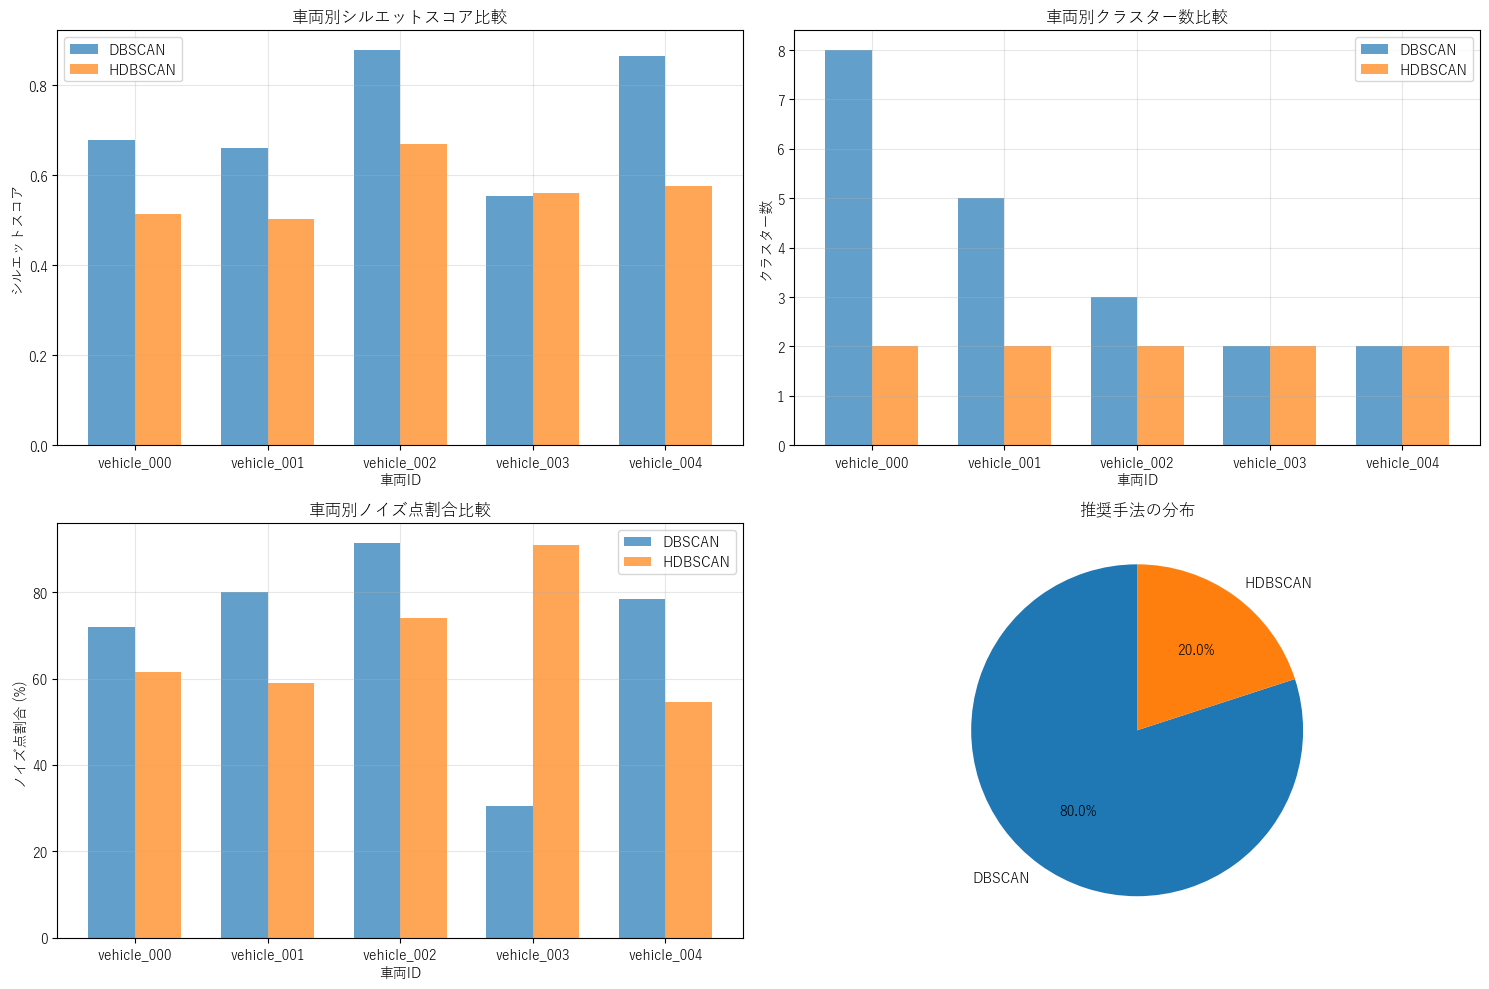

In [27]:
# 車両別の結果比較と分析
print("=== 車両別の結果比較と分析 ===")

# 全体の比較結果をまとめる
comparison_summary = []

for vehicle_hashvin, results in vehicle_clustering_results.items():
    print(f"\n{'='*50}")
    print(f"{vehicle_hashvin} の分析結果")
    print(f"{'='*50}")
    
    # DBSCAN結果
    if results['dbscan_params']:
        dbscan_clusters = len(set(results['dbscan_labels'])) - (1 if -1 in results['dbscan_labels'] else 0)
        dbscan_noise = list(results['dbscan_labels']).count(-1)
        dbscan_noise_ratio = dbscan_noise / len(results['dbscan_labels'])
        
        print(f"DBSCAN:")
        print(f"  パラメータ: eps={results['dbscan_params']['eps']}, min_samples={results['dbscan_params']['min_samples']}")
        print(f"  クラスター数: {dbscan_clusters}")
        print(f"  ノイズ点: {dbscan_noise} ({dbscan_noise_ratio*100:.1f}%)")
        print(f"  シルエットスコア: {results['dbscan_score']:.4f}")
    else:
        print("DBSCAN: 有効な結果なし")
        dbscan_clusters = 0
        dbscan_noise = len(results['data'])
        dbscan_noise_ratio = 1.0
        results['dbscan_score'] = -1
    
    # HDBSCAN結果
    if results['hdbscan_params']:
        hdbscan_clusters = len(set(results['hdbscan_labels'])) - (1 if -1 in results['hdbscan_labels'] else 0)
        hdbscan_noise = list(results['hdbscan_labels']).count(-1)
        hdbscan_noise_ratio = hdbscan_noise / len(results['hdbscan_labels'])
        
        print(f"HDBSCAN:")
        print(f"  パラメータ: min_cluster_size={results['hdbscan_params']['min_cluster_size']}, min_samples={results['hdbscan_params']['min_samples']}")
        print(f"  クラスター数: {hdbscan_clusters}")
        print(f"  ノイズ点: {hdbscan_noise} ({hdbscan_noise_ratio*100:.1f}%)")
        print(f"  シルエットスコア: {results['hdbscan_score']:.4f}")
    else:
        print("HDBSCAN: 有効な結果なし")
        hdbscan_clusters = 0
        hdbscan_noise = len(results['data'])
        hdbscan_noise_ratio = 1.0
        results['hdbscan_score'] = -1
    
    # 推奨手法の判定
    if results['dbscan_score'] > results['hdbscan_score']:
        recommended = 'DBSCAN'
        print(f"推奨手法: DBSCAN (スコア: {results['dbscan_score']:.4f})")
    elif results['hdbscan_score'] > results['dbscan_score']:
        recommended = 'HDBSCAN'
        print(f"推奨手法: HDBSCAN (スコア: {results['hdbscan_score']:.4f})")
    else:
        recommended = '同等'
        print("推奨手法: 同等")
    
    # 比較結果を記録
    comparison_summary.append({
        'hashvin': vehicle_hashvin,
        'data_points': len(results['data']),
        'dbscan_clusters': dbscan_clusters,
        'dbscan_noise_ratio': dbscan_noise_ratio,
        'dbscan_score': results['dbscan_score'],
        'hdbscan_clusters': hdbscan_clusters,
        'hdbscan_noise_ratio': hdbscan_noise_ratio,
        'hdbscan_score': results['hdbscan_score'],
        'recommended': recommended
    })

# 全体の比較結果をDataFrameで表示
comparison_df = pd.DataFrame(comparison_summary)
print(f"\n{'='*80}")
print("全体の比較結果サマリー")
print(f"{'='*80}")
print(comparison_df)

# 統計的な分析
print(f"\n{'='*80}")
print("統計的な分析")
print(f"{'='*80}")

# DBSCAN vs HDBSCAN の勝率
dbscan_wins = sum(1 for row in comparison_summary if row['dbscan_score'] > row['hdbscan_score'])
hdbscan_wins = sum(1 for row in comparison_summary if row['hdbscan_score'] > row['dbscan_score'])
ties = sum(1 for row in comparison_summary if row['dbscan_score'] == row['hdbscan_score'])

print(f"DBSCAN勝利: {dbscan_wins}車両")
print(f"HDBSCAN勝利: {hdbscan_wins}車両")
print(f"引き分け: {ties}車両")

# 平均スコア
avg_dbscan_score = comparison_df['dbscan_score'].mean()
avg_hdbscan_score = comparison_df['hdbscan_score'].mean()

print(f"\n平均シルエットスコア:")
print(f"  DBSCAN: {avg_dbscan_score:.4f}")
print(f"  HDBSCAN: {avg_hdbscan_score:.4f}")

# 可視化
plt.figure(figsize=(15, 10))

# スコア比較
plt.subplot(2, 2, 1)
x_pos = np.arange(len(comparison_df))
width = 0.35
plt.bar(x_pos - width/2, comparison_df['dbscan_score'], width, label='DBSCAN', alpha=0.7)
plt.bar(x_pos + width/2, comparison_df['hdbscan_score'], width, label='HDBSCAN', alpha=0.7)
plt.xlabel('車両ID')
plt.ylabel('シルエットスコア')
plt.title('車両別シルエットスコア比較')
plt.xticks(x_pos, comparison_df['hashvin'])
plt.legend()
plt.grid(True, alpha=0.3)

# クラスター数比較
plt.subplot(2, 2, 2)
plt.bar(x_pos - width/2, comparison_df['dbscan_clusters'], width, label='DBSCAN', alpha=0.7)
plt.bar(x_pos + width/2, comparison_df['hdbscan_clusters'], width, label='HDBSCAN', alpha=0.7)
plt.xlabel('車両ID')
plt.ylabel('クラスター数')
plt.title('車両別クラスター数比較')
plt.xticks(x_pos, comparison_df['hashvin'])
plt.legend()
plt.grid(True, alpha=0.3)

# ノイズ点割合比較
plt.subplot(2, 2, 3)
plt.bar(x_pos - width/2, comparison_df['dbscan_noise_ratio']*100, width, label='DBSCAN', alpha=0.7)
plt.bar(x_pos + width/2, comparison_df['hdbscan_noise_ratio']*100, width, label='HDBSCAN', alpha=0.7)
plt.xlabel('車両ID')
plt.ylabel('ノイズ点割合 (%)')
plt.title('車両別ノイズ点割合比較')
plt.xticks(x_pos, comparison_df['hashvin'])
plt.legend()
plt.grid(True, alpha=0.3)

# 推奨手法の分布
plt.subplot(2, 2, 4)
recommended_counts = comparison_df['recommended'].value_counts()
plt.pie(recommended_counts.values, labels=recommended_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('推奨手法の分布')

plt.tight_layout()
plt.show()

### 車両別の地図生成

In [29]:
# 車両別の地図生成
print("=== 車両別の地図生成 ===")

# クラスター別の色リスト
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
          'beige', 'darkgreen', 'darkblue', 'darkpurple', 'pink', 'lightblue', 
          'lightgreen', 'gray', 'black', 'lightgray']

for vehicle_hashvin, results in vehicle_clustering_results.items():
    print(f"\n{vehicle_hashvin} の地図を生成中...")
    
    vehicle_data = results['data']
    dbscan_labels = results['dbscan_labels']
    hdbscan_labels = results['hdbscan_labels']
    
    # 車両データの中心座標
    center_lat = vehicle_data['lat_m'].mean()
    center_lon = vehicle_data['lon_m'].mean()
    
    # 地図の作成
    m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles='OpenStreetMap')
    
    # レイヤーグループを作成
    dbscan_group = folium.FeatureGroup(name='DBSCAN結果')
    hdbscan_group = folium.FeatureGroup(name='HDBSCAN結果')
    
    # DBSCAN結果を地図上にプロット（修正版）
    for i, (idx, row) in enumerate(vehicle_data.iterrows()):  # enumerate を使用してiを取得
        cluster_id = dbscan_labels[i]  # 配列のインデックスiを使用
        if cluster_id == -1:
            # ノイズ点は小さな黒い点で表示
            folium.CircleMarker(
                location=[row['lat_m'], row['lon_m']],
                radius=3,
                color='black',
                fill=True,
                fillColor='black',
                fillOpacity=0.7,
                popup=f'DBSCAN ノイズ点<br>idle_time: {row["idle_time"]:.1f}分',
                tooltip=f'DBSCAN ノイズ'
            ).add_to(dbscan_group)
        else:
            # クラスター点は色分けして表示
            color = colors[cluster_id % len(colors)]
            folium.CircleMarker(
                location=[row['lat_m'], row['lon_m']],
                radius=4,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7,
                popup=f'DBSCAN クラスター{cluster_id}<br>idle_time: {row["idle_time"]:.1f}分',
                tooltip=f'DBSCAN C{cluster_id}'
            ).add_to(dbscan_group)
    
    # HDBSCAN結果を地図上にプロット（修正版）
    for i, (idx, row) in enumerate(vehicle_data.iterrows()):  # enumerate を使用してiを取得
        cluster_id = hdbscan_labels[i]  # 配列のインデックスiを使用
        # 位置を少しずらして重複を避ける
        lat_offset = 0.0005  # 約50m程度のオフセット
        lon_offset = 0.0005
        
        if cluster_id == -1:
            # ノイズ点は小さな灰色の点で表示
            folium.CircleMarker(
                location=[row['lat_m'] + lat_offset, row['lon_m'] + lon_offset],
                radius=3,
                color='gray',
                fill=True,
                fillColor='gray',
                fillOpacity=0.7,
                popup=f'HDBSCAN ノイズ点<br>idle_time: {row["idle_time"]:.1f}分',
                tooltip=f'HDBSCAN ノイズ'
            ).add_to(hdbscan_group)
        else:
            # クラスター点は色分けして表示（四角形で区別）
            color = colors[cluster_id % len(colors)]
            folium.RegularPolygonMarker(
                location=[row['lat_m'] + lat_offset, row['lon_m'] + lon_offset],
                number_of_sides=4,
                radius=4,
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7,
                popup=f'HDBSCAN クラスター{cluster_id}<br>idle_time: {row["idle_time"]:.1f}分',
                tooltip=f'HDBSCAN C{cluster_id}'
            ).add_to(hdbscan_group)
    
    # クラスター中心を表示
    # DBSCANクラスター中心
    unique_dbscan_clusters = set(dbscan_labels)
    for cluster_id in unique_dbscan_clusters:
        if cluster_id != -1:
            # クラスターに属するポイントのマスクを作成
            cluster_mask = np.array(dbscan_labels) == cluster_id
            cluster_points = vehicle_data.iloc[cluster_mask]  # iloc を使用
            
            if len(cluster_points) > 0:
                center_lat = cluster_points['lat_m'].mean()
                center_lon = cluster_points['lon_m'].mean()
                
                folium.Marker(
                    location=[center_lat, center_lon],
                    icon=folium.Icon(color='red', icon='star'),
                    popup=f'DBSCAN クラスター{cluster_id}中心<br>ポイント数: {len(cluster_points)}',
                    tooltip=f'DBSCAN C{cluster_id}中心'
                ).add_to(dbscan_group)
    
    # HDBSCANクラスター中心
    unique_hdbscan_clusters = set(hdbscan_labels)
    for cluster_id in unique_hdbscan_clusters:
        if cluster_id != -1:
            # クラスターに属するポイントのマスクを作成
            cluster_mask = np.array(hdbscan_labels) == cluster_id
            cluster_points = vehicle_data.iloc[cluster_mask]  # iloc を使用
            
            if len(cluster_points) > 0:
                center_lat = cluster_points['lat_m'].mean()
                center_lon = cluster_points['lon_m'].mean()
                
                folium.Marker(
                    location=[center_lat + 0.0005, center_lon + 0.0005],
                    icon=folium.Icon(color='blue', icon='certificate'),
                    popup=f'HDBSCAN クラスター{cluster_id}中心<br>ポイント数: {len(cluster_points)}',
                    tooltip=f'HDBSCAN C{cluster_id}中心'
                ).add_to(hdbscan_group)
    
    # レイヤーを地図に追加
    dbscan_group.add_to(m)
    hdbscan_group.add_to(m)
    
    # レイヤーコントロールを追加
    folium.LayerControl().add_to(m)
    
    # タイトルを追加
    title_html = f'''
    <h3 align="center" style="font-size:16px">
        {vehicle_hashvin} - クラスタリング結果比較
    </h3>
    '''
    m.get_root().html.add_child(folium.Element(title_html))
    
    # 凡例の追加
    legend_html = f'''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 250px; height: 300px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:12px; padding: 10px">
                <p><b>{vehicle_hashvin} クラスタリング結果</b></p>
                <p><b>DBSCAN:</b></p>
                <p>● 丸いマーカー（クラスター点）</p>
                <p>● 黒い点（ノイズ）</p>
                <p>⭐ 赤い星（クラスター中心）</p>
                <br>
                <p><b>HDBSCAN:</b></p>
                <p>■ 四角いマーカー（クラスター点）</p>
                <p>■ 灰色の点（ノイズ）</p>
                <p>🏆 青いアイコン（クラスター中心）</p>
                <br>
                <p><i>レイヤーコントロールで切り替え可能</i></p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # 地図を保存
    filename = f'{vehicle_hashvin}_clustering_map.html'
    m.save(filename)
    print(f"地図を '{filename}' として保存しました")

print(f"\n全車両の地図生成完了: {len(vehicle_clustering_results)}車両分")

=== 車両別の地図生成 ===

vehicle_000 の地図を生成中...
地図を 'vehicle_000_clustering_map.html' として保存しました

vehicle_001 の地図を生成中...
地図を 'vehicle_001_clustering_map.html' として保存しました

vehicle_002 の地図を生成中...
地図を 'vehicle_002_clustering_map.html' として保存しました

vehicle_003 の地図を生成中...
地図を 'vehicle_003_clustering_map.html' として保存しました

vehicle_004 の地図を生成中...
地図を 'vehicle_004_clustering_map.html' として保存しました

全車両の地図生成完了: 5車両分


### 結果の要約と分析

In [30]:
# 結果の要約と分析
print("=== 結果の要約と分析 ===")

print(f"\n{'='*80}")
print("クラスタリング分析の総合結果")
print(f"{'='*80}")

# 各車両の詳細結果
for vehicle_hashvin, results in vehicle_clustering_results.items():
    print(f"\n{vehicle_hashvin}:")
    print(f"  データポイント数: {len(results['data'])}")
    
    if results['dbscan_params']:
        print(f"  DBSCAN: {results['dbscan_params']} (スコア: {results['dbscan_score']:.4f})")
    else:
        print(f"  DBSCAN: 有効な結果なし")
    
    if results['hdbscan_params']:
        print(f"  HDBSCAN: {results['hdbscan_params']} (スコア: {results['hdbscan_score']:.4f})")
    else:
        print(f"  HDBSCAN: 有効な結果なし")

# 全体の傾向分析
print(f"\n{'='*80}")
print("全体の傾向分析")
print(f"{'='*80}")

# パラメータの傾向
print("\n--- 最適パラメータの傾向 ---")

# DBSCANパラメータの傾向
eps_values_used = [results['dbscan_params'].get('eps', 0) for results in vehicle_clustering_results.values() if results['dbscan_params']]
min_samples_dbscan_used = [results['dbscan_params'].get('min_samples', 0) for results in vehicle_clustering_results.values() if results['dbscan_params']]

if eps_values_used:
    print(f"DBSCAN eps値の傾向:")
    print(f"  最小値: {min(eps_values_used)}")
    print(f"  最大値: {max(eps_values_used)}")
    print(f"  平均値: {np.mean(eps_values_used):.0f}")

if min_samples_dbscan_used:
    print(f"DBSCAN min_samples値の傾向:")
    print(f"  最小値: {min(min_samples_dbscan_used)}")
    print(f"  最大値: {max(min_samples_dbscan_used)}")
    print(f"  平均値: {np.mean(min_samples_dbscan_used):.1f}")

# HDBSCANパラメータの傾向
min_cluster_size_used = [results['hdbscan_params'].get('min_cluster_size', 0) for results in vehicle_clustering_results.values() if results['hdbscan_params']]
min_samples_hdbscan_used = [results['hdbscan_params'].get('min_samples', 0) for results in vehicle_clustering_results.values() if results['hdbscan_params']]

if min_cluster_size_used:
    print(f"HDBSCAN min_cluster_size値の傾向:")
    print(f"  最小値: {min(min_cluster_size_used)}")
    print(f"  最大値: {max(min_cluster_size_used)}")
    print(f"  平均値: {np.mean(min_cluster_size_used):.1f}")

if min_samples_hdbscan_used:
    print(f"HDBSCAN min_samples値の傾向:")
    print(f"  最小値: {min(min_samples_hdbscan_used)}")
    print(f"  最大値: {max(min_samples_hdbscan_used)}")
    print(f"  平均値: {np.mean(min_samples_hdbscan_used):.1f}")

# 推奨事項
print(f"\n{'='*80}")
print("推奨事項")
print(f"{'='*80}")

print("1. パラメータ設定の指針:")
print("   - DBSCAN: eps値は1000-5000mの範囲で試行することを推奨")
print("   - HDBSCAN: min_cluster_sizeは10-20の範囲で試行することを推奨")
print("   - min_samplesはデータサイズの5-10%程度に設定することを推奨")

print("\n2. 手法選択の指針:")
print("   - 密度が均一なデータ: DBSCANが適している")
print("   - 密度が不均一なデータ: HDBSCANが適している")
print("   - 各車両のデータ特性に応じて個別に評価することを推奨")

print("\n3. 実装時の注意点:")
print("   - データポイントが少ない車両（10未満）はクラスタリングをスキップ")
print("   - シルエットスコアが負の値の場合は結果を信頼しない")
print("   - ノイズ点の割合が50%を超える場合はパラメータの見直しを検討")

print(f"\n分析完了！各車両の地図ファイルが生成されています。")

=== 結果の要約と分析 ===

クラスタリング分析の総合結果

vehicle_000:
  データポイント数: 200
  DBSCAN: {'eps': 500, 'min_samples': 5} (スコア: 0.6793)
  HDBSCAN: {'min_cluster_size': 15, 'min_samples': 5} (スコア: 0.5144)

vehicle_001:
  データポイント数: 200
  DBSCAN: {'eps': 500, 'min_samples': 5} (スコア: 0.6613)
  HDBSCAN: {'min_cluster_size': 15, 'min_samples': 5} (スコア: 0.5034)

vehicle_002:
  データポイント数: 200
  DBSCAN: {'eps': 500, 'min_samples': 5} (スコア: 0.8784)
  HDBSCAN: {'min_cluster_size': 5, 'min_samples': 20} (スコア: 0.6696)

vehicle_003:
  データポイント数: 200
  DBSCAN: {'eps': 1000, 'min_samples': 5} (スコア: 0.5540)
  HDBSCAN: {'min_cluster_size': 5, 'min_samples': 10} (スコア: 0.5611)

vehicle_004:
  データポイント数: 200
  DBSCAN: {'eps': 1000, 'min_samples': 15} (スコア: 0.8650)
  HDBSCAN: {'min_cluster_size': 15, 'min_samples': 15} (スコア: 0.5751)

全体の傾向分析

--- 最適パラメータの傾向 ---
DBSCAN eps値の傾向:
  最小値: 500
  最大値: 1000
  平均値: 700
DBSCAN min_samples値の傾向:
  最小値: 5
  最大値: 15
  平均値: 7.0
HDBSCAN min_cluster_size値の傾向:
  最小値: 5
  最大値: 15
  平均値: 11.0
HDBS